In [1]:
from ndslib.config import jupyter_startup
jupyter_startup()

from ndslib.data import load_data
abide_data = load_data("abide2")
features = abide_data.filter(like='fs')
# We'll use age as our prediction target throughout this section
y = abide_data['age']

# We fix the random seed, so that we get predictable results below
import numpy as np
np.random.seed(2022)

(ml-validation)=
# Validation

Now that we have a basic handle on overfitting, we can start thinking about ways
to mitigate this problem. In this section, we'll cover methods for validating
our models. That is, obtaining better estimates of their true capabilities and
identifying situations where they're behaving in undesirable ways. While model
validation doesn't *directly* prevent overfitting, it plays an important
indirect role. If we don't have a good way to recognize overfitting when it
happens, we're not going to be in a great position to mitigate it.

## Cross-validation

An important insight we introduced in the last section is that a model will
usually perform better when evaluated on the same data it was trained on than
when evaluated on an entirely new dataset. Since our models are of little use to
us unless they can generalize to new data, we should probably care much more
about how a model performs on new data than on data it's already seen. That is,
we want what's known as an **out-of-sample** estimate of performance.

The most straightforward way to estimate out-of-sample performance is to ensure
that we always train and evaluate our model on separate, independent datasets.
The performance estimate obtained from the training dataset -- the dataset used
to fit the model -- will typically suffer from overfitting to some degree; an
estimate on the test dataset -- the dataset that was set aside in advance for
this purpose -- will not, so long as the noise in this data is independent of
that in the training dataset.

In practice, an easy way to construct training and test datasets with
independent errors is to randomly split a dataset in two. We'll continue working
with the ABIDE2 data that we started working with previously. Now, we will make
use of Scikit-learn's `train_test_split` utility, found in the `model selection`
module of the library to do the work for us. The way this function works is by
splitting an arbitrary number of array-like objects into training and testing
subsets. For every array we pass to train_test_split, we get back two: a
training set, and a test set. the `train_size` parameter controls the proportion
of all cases assigned to the training set, with the remainder assigned to the
test set. In the call below, X and y will each contain a randomly selected half
of the dataset. One part of the data gets designated as training data and the
other part gets designated as test data.

In [2]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, y, train_size=0.5)

The practice of fitting our estimator to the training data, and then evaluating
its performance on the test data is called **cross-validation**, and it is
ubiquitous in machine learning. Here, we will evaluate the result with both the
training and the test data. The performance difference between the two will tell
us how badly we're overfitting the training data. For example, we can use a
linear regression model to predict age from all 1,440 structural MRI features in
the ABIDE-II dataset. Notice that at the end  are now calculating the $R^2$
separately for the training sample and the testing sample:

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

est = LinearRegression()

est.fit(X_train, y_train)

print(f"R^2 in training sample: ", est.score(X_train, y_train))
print(f"R^2 in test sample: ", est.score(X_test, y_test))

R^2 in training sample:  1.0
R^2 in test sample:  -0.9248898341781526


The difference here is remarkable. In the training sample, the fitted model
explains 100% of the variance. In the test sample, it explains... well, none.
The $R^2$ value is negative -— implying that our model is predictively
worthless! If you're used to computing $R^2$ by taking the square of a
correlation coefficient, you might think an $R^2$ value below 0 must be an
error, but it isn't. The standard definition of $R^2$ as the coefficient of
determination is 1 minus the ratio of the model squared errors (MSE) to the
variance of the data. This allows arbitrarily large negative values because the
MSE can be larger than the variance if the model is sufficiently poorly fit.
Intuitively, we can have an estimator that's so bad, we would have been better
off just using the mean of the new data as our prediction, in which case the MSE
would be identical to the variance, based on the definition of the variance, and
$R^2=0$.

```{eval-rst}
.. index::
   single: Coefficient of determination
```

### When less is more

The reason our linear regression model overfits the data is that, just as in our
earlier simulated example, the model has too much flexibility: the number of
features is large relative to the number of available training samples. Some
neuroimaging researchers might find this statement a bit surprising, seeing as
the training dataset still contains over 500 subjects, and that's a pretty large
sample by the standards of most MRI experiments. But the absolute number of
subjects has little bearing on the propensity of a model to overfit; what
matters most is the *ratio* between the model's effective degrees of freedom and
the number of samples. In our case, even if we think 500 subjects is a lot (as
we well might, if we're used to working with small MRI samples), we still have
far more features (1,440).

If our model is overfitting because it has too many features and not enough
training data, a simple way to mitigate overfitting should be to use fewer
features. Let's see what happens if we randomly sample just 200 of the 1440
features. That way we'll have more samples than features.

In [4]:
X = features.sample(200, axis='columns', random_state=99)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, random_state=99)
est.fit(X_train, y_train)
print(f"R^2 in training sample: ", est.score(X_train, y_train))
print(f"R^2 in test sample: ", est.score(X_test, y_test))

R^2 in training sample:  0.7915613296581236
R^2 in test sample:  0.4576792069129787


That looks much better! Notice that there's still a big gap between in-sample
(i.e., training) and out-of-sample (test) performance. But at least now we know
that our model *is* capable of predicting age reasonably well in subjects it
hasn't seen before.

### K-fold cross-validation

Splitting our data into training and test sets is a great way to evaluate our
model's out-of-sample performance, but it comes at a cost: it
*increases* the model's propensity to overfit the training data because we've
halved our training sample. As a result, our model has less data to work with,
which means it will be more likely to capitalize on chance and fit noise. So, at
first glance, it looks like we're stuck in a Catch-22: if we use all of our data
to train the model, our estimate of the model's true (i.e., out-of-sample)
predictive performance is likely to be heavily biased. Conversely, if we split
our data into separate training and testing subsets, we get a less biased
estimate of the model's true performance, but the cost is that our model won't
perform as well, because we're giving it less data to learn from.

Is there a way to have our cake and eat it too? In this case, as it turns out,
yes! The solution is to use a form of cross-validation known as $k$-fold
cross-validation. The idea here is very similar to splitting our data into
training and testing halves. If we set $k$—a parameter that represents the
number of *folds*, or data subsets—to 2, we again end up with two discrete
subsets of the data.

But now, there's an important twist: instead of using half of the data for
training and the other half for testing, we're going to use both halves for both
training and testing. The key is that we'll take turns. First, we'll use Half 1
to train, and Half 2 to test; then, we'll reverse the process. Our final
estimate of the model's out-of-sample performance is obtained by averaging the
performance estimates we got from the two testing halves. In this way, we've
managed to use every single one of our data points for both training and
testing, but -— critically -— never for both at the same time.

Of course, we don't have to set $k$ to 2; we can set it to any other value
between 2 and the total sample size $n$. At the limit, if we set $k = n$, the
approach is called *leave-one-out cross-validation* (because in every fold, we
leave out a single data point for testing, and use the rest of the dataset for
training). In practice, $k$ is most commonly set to a value in the range of 3 - 1.  There's a long-running debate over what values of $k$ are optimal under what conditions, and why, but we won't get into that here. (If you ever find yourself in a situation where your results change non-trivially depending on the value of $k$ you pick, you might want to take that as a sign that your training dataset is too small.)

![cross-validation](./figures/cv.png)


### K-folds the explicit way

To illustrate how k-folds cross-validation works, let's implement it ourselves.
First, we create $k$ different subsets of the original dataset. Then, we loop
over the $k$ subsets and, in each case, use the current subset to test the model
trained on the remaining $k$-1 subsets. Finally, we average over the performance
estimates obtained from all $k$ folds to obtain our overall out-of-sample
performance estimate. If you're not interested in wading through the code, you
can skip to the next subsection, where we replace most of this with a single
line.

First, let's set a value for $k$

In [5]:
k = 5

We initialize placeholders for the results using `numpy.zeros()` and initialize
the `LinearRegression` object we will use for fitting.

In [6]:
import numpy as np
train_r2 = np.zeros(5)
test_r2 = np.zeros(5)
est = LinearRegression()

Python comes with a library for the generation of randomness (getting a computer to
behave randomly is trickier than you think!). Here, we will use the shuffle
function from this library, which takes a list and reorganizes it in random
order. In this case, we will organize the numbers 0 thru the number of rows in
X.

In [7]:
from random import shuffle
indices = list(range(len(X)))
shuffle(indices)

We loop over the folds. In each fold, we select every $k$-th index to belong to
the training set. Next, we designate all the indices not chosen to be test-set
samples as training indices (we use a list comprehension -- see `numref`{python}
if you need a reminder). The linear regression is fit to the training data. In
each iteration, we score the model with both the training and the testing data.
When we are done, we have five estimates of $R^2$ based on five fits of the
model.

In [8]:
for i in range(k):
    test = indices[i::k]
    train = [jj for jj in indices if jj not in test]
    X_train = X.iloc[train]
    X_test = X.iloc[test]
    y_train = y.iloc[train]
    y_test = y.iloc[test]

    est.fit(X_train, y_train)

    train_r2[i] = est.score(X_train, y_train)
    test_r2[i] = est.score(X_test, y_test)

print("Fold scores in training: ", train_r2)
print("Mean training R^2 over folds: ", np.mean(train_r2))

print("Fold scores in test: ", test_r2)
print("Mean training R^2 over folds: ", np.mean(test_r2))

Fold scores in training:  [0.7541753  0.75480221 0.75336564 0.75593833 0.73950635]
Mean training R^2 over folds:  0.7515575691984748
Fold scores in test:  [0.60423647 0.54275829 0.5041441  0.55791566 0.64700061]
Mean training R^2 over folds:  0.5712110269986821


Notice that the results of the 5-fold cross-validation differ from those we got
when we used 50% of the data to train the model and 50% of it to test the model.
Our in-sample performance is lower now (0.79 vs. 0.75), but our out-of-sample
performance -— which is what we care about -— is higher (0.46 vs. 0.55).

(ml-validation_ex1)=
#### Exercise

Why do you think out-of-sample accuracy is higher in this setting? What is the downside of having higher average out-of-sample accuracy in this case?

### K-folds the easy way

K-folds is an extremely common validation strategy, so any machine learning
package worth its salt should provide us with some friendly tools we can use to
avoid having to reimplement the basic procedure over and over. In Scikit-learn,
the `cross_validation` module contains several useful utilities. We've already
seen `train_test_split`, which we could use to save us some time. But if all we
want to do is get cross-validated scores for some estimator, it's even faster to
use the `cross_val_score` function. The function takes an estimator, the inputs
to the `fit` method, and an optional specification of the cross-validation
procedure. Integers are interpreted as the number of folds to use in a k-folds
partitioning (but there are other possible inputs to the `cv` key-word argument,
which we will not discuss here)

In [9]:
from sklearn.model_selection import cross_val_score
r2_cv = cross_val_score(est, X, y, cv=k)

print("Individual fold scores:", r2_cv)
print(f"\nMean cross-validated R^2: ", np.mean(r2_cv))

Individual fold scores: [0.60389708 0.53795077 0.56791833 0.56837218 0.55742804]

Mean cross-validated R^2:  0.5671132813920104


That's it! We were able to replace nearly all of our code above with one
function call. If you find this a little *too* magical, Scikit-learn also has a
bunch of other utilities that offer an intermediate level of abstraction (For
example, the `sklearn.model_selection.KFold` class will generate the folds for
you, but will return the training and test indices for you to loop over, rather
than automatically cross-validating your estimator).

### Cross-validation isn't a panacea

There's a reason cross-validation is so popular: it provides an easy way to
estimate the out-of-sample performance of just about any estimator, with minimal
bias or loss of efficiency. But it isn't magic. One problem it does nothing to
solve is that of interpretation. It's tempting to conclude from our healthy
$R^2$ above that we've shown that there's some important causal relationship
between brain structure and chronological age. Unfortunately, the fact that our
model seems to predict age pretty well doesn't mean we know *why* it's
predicting age pretty well. We don't even know that its predictive power derives
from anything to do with the brain *per se*. It's possible that our
brain-derived features just happen to be correlated with other non-brain
features we didn't measure, and that it's the omitted variables that are doing
the causal work for us. This might not bother us if we *only* cared about making
good predictions. But it could be a very serious problem if we're using machine
learning as an instrument to advance scientific understanding. If it turns out
that the brain features in our dataset are highly correlated with some other
variable(s), that might radically change our interpretation of what our model's
doing.

As it happens, the brain variables in our dataset *are* correlated with at least
one variable that's very strongly associated with age: research site. The
ABIDE-II dataset we're working with contains scans from 17 sites. Let's look at
how age varies by site (we'll use the Seaborn library for the visualization)

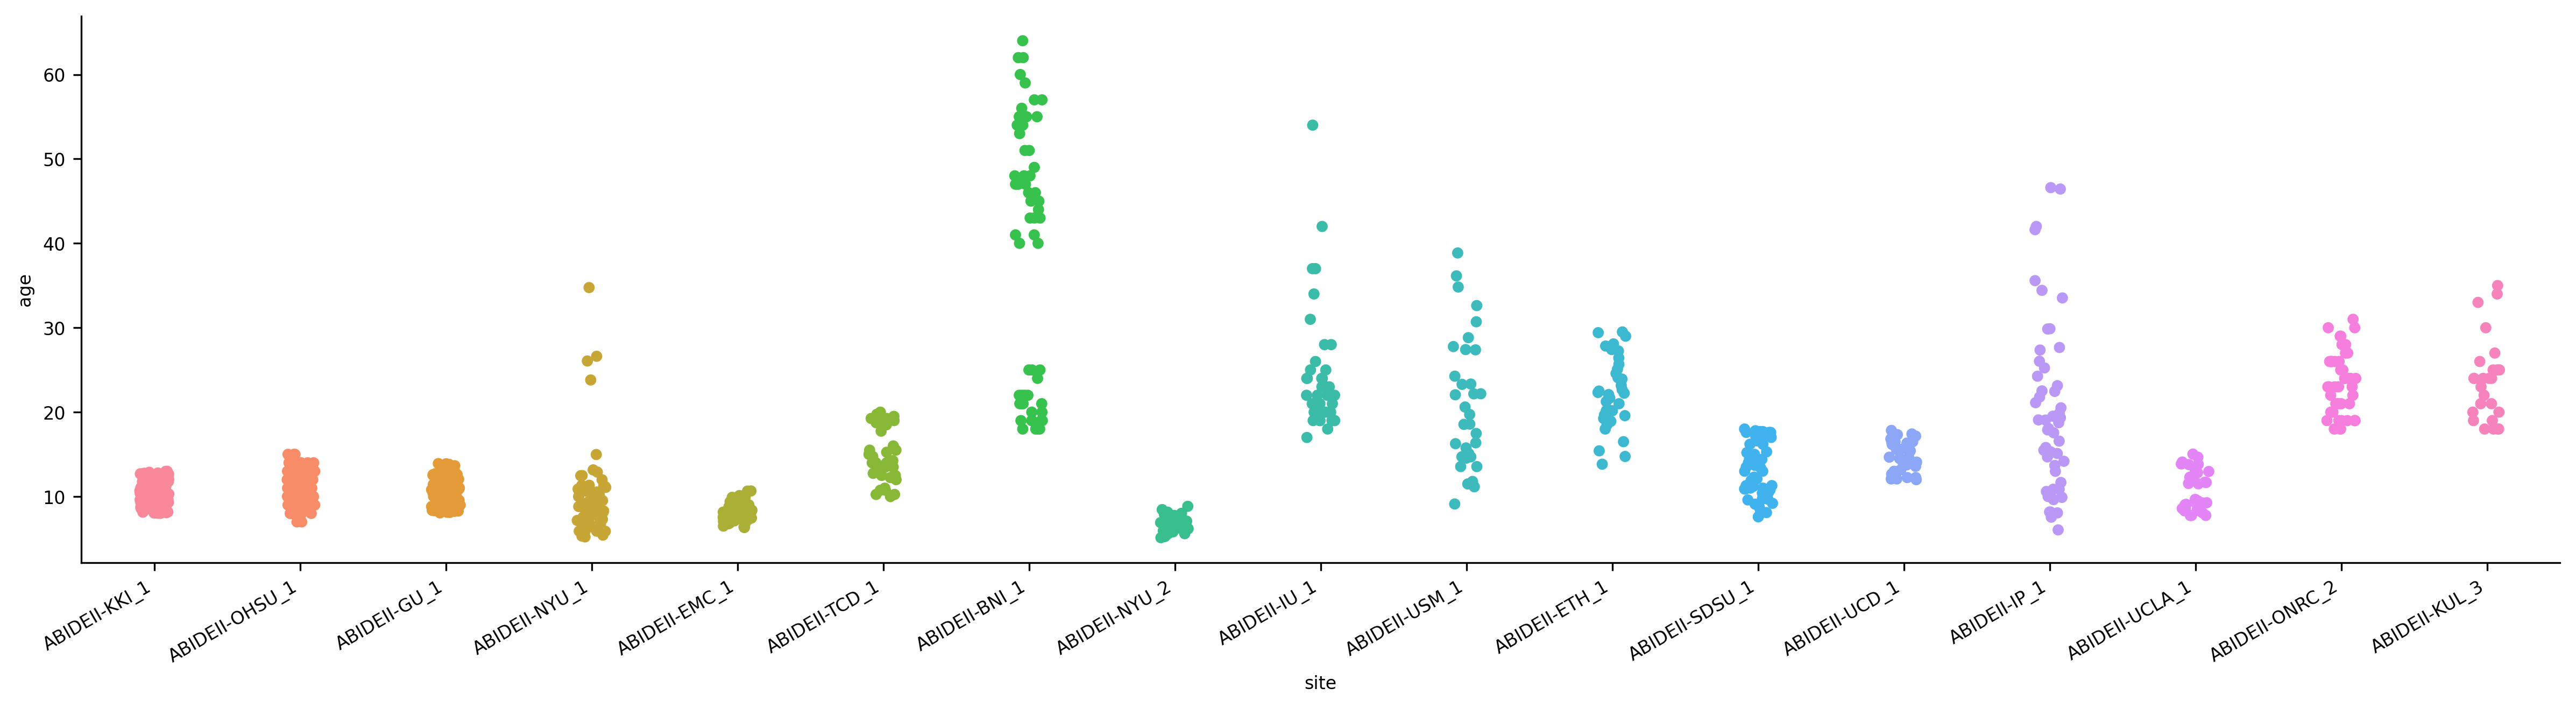

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
g = sns.catplot(x='site', y='age', data=abide_data, kind='strip', height=4, aspect=4)
g = g.set_xticklabels(rotation=30, horizontalalignment='right')

```{eval-rst}
.. index::
   single: Seaborn
```

In the above plot, each strip is a different site, and each point is a single
subject. As we can clearly see, sites do indeed vary wildly in their age
distributions. For example, the NYU site scanned only very young children (<
10), whereas the BNI site scanned mostly adults over 40.

The fact that site differences are so big is worrisome, in one sense, as it
raises the possibility that at least some of the predictive power of our model
might derive from spurious associations between the research site and our brain
features—i.e., that if we were to "adjust" age to account for between-site
differences, the brain features might no longer do quite as much work for us in
predicting age.


(ml-validation_ex2)=
#### Exercise

There are various ways we can go about adjusting age prediction for research site. A
simple but very conservative one is to residualize age on research site. That
is, we remove all the variance in the age that can be explained by between-site
differences. To save time, we've included an already-residualized version of the
age variable in our dataset; it's in the "age_resid" column. Repeat our analysis
above with `'age_resid'` instead of `'age'`. What does the result mean?

### Is it all for naught?

Does this mean we're fooling ourselves, and should just give up now? No! As
noted above, this particular analysis is *extremely* conservative. Because the
ABIDE-II sites differ so dramatically in age distributions, by controlling for
research sites, we're wiping out most of the variability in age. This would make
it much harder to predict age from the brain features even if it was the site
effects that were completely spurious. The root problem is that we can't tell,
just from a set of correlations, what the correct causal model is.

The reality is that causal interpretation of observational data is hard, and
cross-validation doesn't make it any easier. The question of whether or not we
need to adjust for variables like site effects before examining the brain-age
relationship isn't trivial (nor is deciding *how* to adjust for them). For now,
we'll ignore the effects of the research site, or any other potential
confounders, and just try to predict age directly from the brain variables. Just
be aware that if we were planning to share these results with the rest of the
world (for example, in a paper reporting what we've found), we'd probably need
to think much more carefully about our causal assumptions, and maybe do some
extra work to convince ourselves that there genuinely is a good deal of
information about chronological age being carried by structural differences in
people's brains. We'll come back to related issues toward the end of the
chapter.

## Learning and validation curves

So far, we've focused on cross-validating model performance at a single point in the dataset and parameter space. That is to say, we're asking "how well would our fitted model do if we took it exactly as-is, changing none of its parameters, and applied it to a new dataset sampled from the same population?"

This is an important thing to know, but we can do better. If we want to get
deeper insights into a model's behavior, it's helpful to observe the way it
responds when we systematically vary the size and nature of the data, number, and type of features, model hyperparameters, etc.

In Scikit-learn, we can use the `learning_curve` and `validation_curve`
utilities to flexibly and compactly wrap most of the cross-validation
functionality we've already encountered. The idea behind the **learning curve**
is to graphically display a model's predictive performance as a function of the
model's experience. That is, to visualize how well it learns as the available
data grows. The **validation_curve** is directly analogous, except instead of
varying the size of the data, we systematically vary one of the estimator's
parameters.

```{eval-rst}
.. index::
   single: Validation curve
```

```{eval-rst}
.. index::
   single: Learning curve
```

Let's look at `learning_curve` in more detail. Here's an example:

In [11]:
from sklearn.model_selection import learning_curve

We'll use 100 random features as predictors.

In [12]:
X_subset = X.sample(100, axis=1, random_state=100)

We'll assign a few different sizes of the samples we want to plot model
performance for and use a `LinearRegressor`. Note that we can't go above 800,
because we only have ~1,000 cases, and we're using 80% of the sample for
training.

In [13]:
train_sizes = [100, 200, 400, 800]
est = LinearRegression()

Next, we obtain the learning curve. as with the `cross_val_score` utility, the
cross-validated application of our estimator is done implicitly for us.

In [14]:
results = learning_curve(est, X_subset, y, train_sizes=train_sizes,
                         cv=5, shuffle=True)
sizes, train_scores, test_scores = results

The `train_scores` and `test_scores` arrays contain the performance scores for
training and testing data, respectively. The rows reflect training sizes (i.e.,
in our case, the first row gives performance $n=100$, the second for $n=200$, etc.)
and the columns contain the scores from the $k$ folds of the k-folds
cross-validation procedure.

In [15]:
test_scores.round(2)

array([[-3.7200e+01, -1.5618e+02, -2.4600e+00, -1.2440e+01, -3.8470e+01],
       [ 2.4000e-01,  2.2000e-01,  1.0000e-01,  3.0000e-01,  2.7000e-01],
       [ 4.9000e-01,  4.4000e-01,  5.5000e-01,  5.3000e-01,  4.7000e-01],
       [ 6.0000e-01,  5.7000e-01,  5.8000e-01,  5.5000e-01,  5.8000e-01]])

This information is fairly hard to appreciate in tabular form, so let's average
performance over the columns (i.e., the $k$ folds) and plot it as a function of
the sample size.

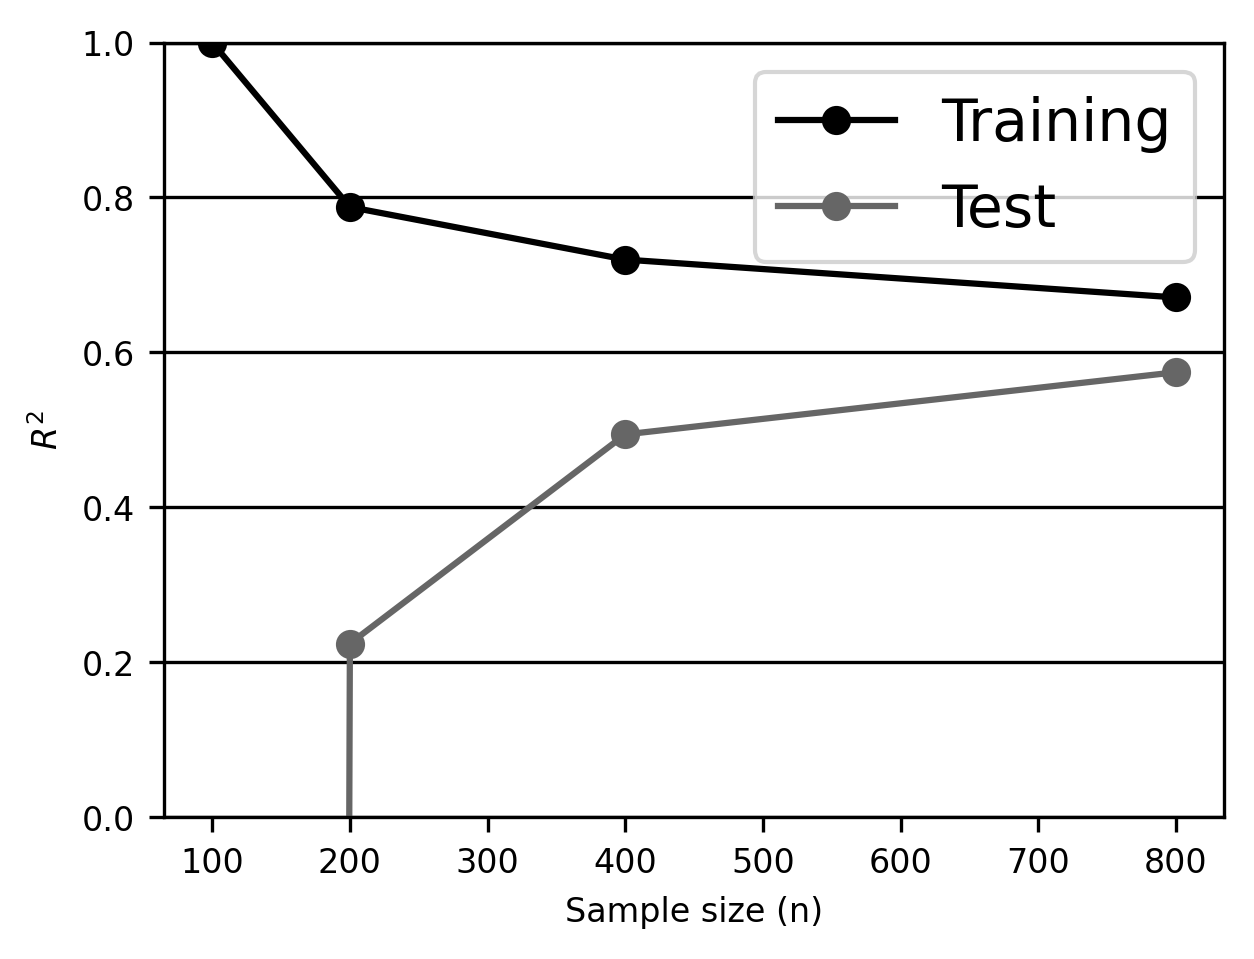

In [16]:
train_mean = train_scores.mean(1)
test_mean = test_scores.mean(1)

fig, ax = plt.subplots()
ax.plot(sizes, train_mean, 'o-', label='Training')
ax.plot(sizes, test_mean, 'o-', label='Test');
ax.grid(True, axis='y')
ax.legend(fontsize=14)
ax.set_ylim(0, 1)
ax.set_xlabel('Sample size (n)')
ax.set_ylabel('$R^2$');

We learn several things from this plot. First, our linear regression estimator
overfits with small samples: $R^2$ in the training samples is near 1 in the
training sample, but is essentially 0 in the test sample. Second, $R^2$ in the
test sample improves monotonically as the training dataset gets larger. This is
a general rule: on average, a model's out-of-sample performance should only get
better as it's trained on more data. Third, note that the training and test
curves never converge, even with the largest sample we have available. This
suggests that we're still overfitting, and we might want to consider either
acquiring more data (if possible) or reducing the model's flexibility (e.g., by
using fewer features, or, as we'll see in later sections, by using a different
model less prone to overfitting).

### Training vs. test vs. validation: a note on nomenclature

Before moving on, a quick note on nomenclature: you will sometimes hear people
talk about "validation" sets rather than (or in addition to) training and test
sets. What this means depends on the context. In many cases, the terms test set
and validation set are used interchangeably to refer to a new dataset
independently of the one the model is trained on. But sometimes, the distinction
between validation and test is important. In particular, it's common to set
aside a "true" hold-out dataset in advance of any validation efforts. In such
cases, the test dataset is the one we use to obtain our final estimate of
performance. The validation dataset, by contrast, is technically part of the
training data (in that we allow ourselves to use it to train the final model),
but it's being used for validation. When we perform a cross-validation procedure
on a training set, we call the hold-out folds the validation sets.

This kind of 3-way split of our data is an excellent way to operate, as it
ensures that we're able to detect overfitting that occurs not only during model estimation but also in the model selection process. For example, if we "cross-validate" 100 models and then choose the one with the best
cross-validated performance, we're still going to overfit to some degree, and
performance in the test dataset will reveal this. Next, let's consider how we
can go one further step towards systematically and automatically choosing the
right model for our data.

![train/val/test split](./figures/cv_tri.png)

(ml-validations_ex3)=
#### Exercise

We've looked at the relationship between training dataset size and model
performance. Here, you will add another dimension to the picture, and try to get
a qualitative sense of how our training and validation curves vary as a function
of model complexity -— in this case, we'll operationalize this as the number of
predictors our linear regression estimator gets to use.

Use the ABIDEII data to predict age given three different sizes of feature sets: 5 features, 30 features, and 100 features, which you select at random. Once again, evaluate performance for sample sizes ranging from 100 to 800.

Does our ability to predict age vary depending on how many features we use? Do the characteristics of overfitting change with the sample size?

We'll return to a discussion of model complexity in the final section of this chapter ({numref}`dl`) when we consider the complexity of deep learning models with many thousands of parameters that can be adjusted.

### Additional resources

Cross-validation is a very powerful tool, but it does not address all of the
challenges of understanding your data. For example, as demonstrated in a paper
by Gaël Varoquaux {cite}`Varoquaux2017-ub`, even when you do use
cross-validation, the errors in your estimate of accuracy can be rather large,
particularly if the sample size is not large enough. The paper is worth reading
and pondering when designing studies that use machine learning methods and
considering the sample size one might need.